<a href="https://colab.research.google.com/github/Madhurika1292/Medicines-and-Common-Treatment-Recommendation-System/blob/main/MRS_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medicine Recommendation System

## Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from textblob import TextBlob
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated", DeprecationWarning)

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import Sequential
from keras.layers import Dense
import random
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from sklearn.metrics import precision_score, f1_score, recall_score





## Data Loading

In [2]:
# Importing dataset from drive
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/Drugscom')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!ls gdrive/MyDrive/Drugscom/

Drugscom_test.csv     Drugscom_train.csv
drugsComTest_raw.csv  drugsComTrain_raw.csv


In [4]:
#Loading data
Drugscom_train=pd.read_csv('/content/gdrive/My Drive/Drugscom/Drugscom_train.csv')
Drugscom_test=pd.read_csv('/content/gdrive/My Drive/Drugscom/Drugscom_test.csv')

In [5]:
#Before
# checking for null values
Drugscom_train.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    6
dtype: int64

In [6]:
# checking for null values
Drugscom_test.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    2
dtype: int64

In [7]:
# Dropping null values
Drugscom_train = Drugscom_train.dropna(axis=0)
Drugscom_test = Drugscom_test.dropna(axis=0)

In [8]:
# checking for null values
Drugscom_train.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    0
dtype: int64

In [9]:
# checking for null values
Drugscom_test.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    0
dtype: int64

In [10]:
#Changing the "Unnamed: 0" column to uniqueId as it represents the unique id of the drugs
Drugscom_train=Drugscom_train.drop('Unnamed: 0', axis='columns')
Drugscom_test=Drugscom_test.drop('Unnamed: 0', axis='columns')

In [11]:
Drugscom_train.head()

,uniqueId,drugName,condition,review,rating,date,usefulCount,treatments,clean_review
0,131173,A / B Otic,Otitis Media,"""It numbs the pain. It makes my ear feel heavi...",10,2009-09-23,20,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",numb pain make ear feel heavier least throb su...
1,153899,Amoxicillin,Otitis Media,"""Perforation in my right tympanic membrane (ea...",8,2011-04-12,16,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",perfor right tympan membran eardrum linger upp...
2,153715,Amoxicillin,Otitis Media,"""This medication did not clear up the infectio...",2,2017-05-31,0,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",medic not clear infect well notic odorless dis...
3,153780,Amoxicillin,Otitis Media,"""My son who was 7 months old at the time was p...",1,2016-12-09,0,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",son month old time prescrib amoxicillin ear in...
4,153838,Amoxicillin,Otitis Media,"""This medication works amazingly for ear infec...",9,2013-10-02,12,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",medic work amaz ear infect ear infect count li...


Above dataset is huge to feed into machine learning model and its unnecessary. So filtering the data with the conditions provided by the user.

In [12]:
#filtering the data with specific condition
def specific_condition_data(df,condition):
  
  return df[df['condition']==condition]

## Splitting data

In [13]:
Drugscom_train.groupby('condition').count()
grouped = Drugscom_train.groupby('condition').count()
grouped.sort_values('uniqueId', ascending=False)

,uniqueId,drugName,review,rating,date,usefulCount,treatments,clean_review
condition,,,,,,,,
Birth Control,28788,28788,28788,28788,28788,28788,28788,28788
Depression,9069,9069,9069,9069,9069,9069,9069,9069
Pain,6145,6145,6145,6145,6145,6145,6145,6145
Anxiety,5903,5903,5903,5903,5903,5903,5903,5903
Acne,5588,5588,5588,5588,5588,5588,5588,5588
...,...,...,...,...,...,...,...,...
Campylobacter Gastroenteritis,2,2,2,2,2,2,2,2
Hairy Cell Leukemia,2,2,2,2,2,2,2,2
Typhoid Fever,2,2,2,2,2,2,2,2


In [14]:
#creating training and testing data set
training_data=specific_condition_data(Drugscom_train,'Anxiety')
testing_data=specific_condition_data(Drugscom_test,'Anxiety')

In [15]:
#creating textblob instance for polarity and subjectivity
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

In [16]:
# applying polarity and subjectivity instance to reviews within data
training_data['polarity'] = training_data["clean_review"].apply(pol)
training_data['subjectivity'] = training_data["clean_review"].apply(sub)
testing_data['polarity'] = testing_data["clean_review"].apply(pol)
testing_data['subjectivity'] = testing_data["clean_review"].apply(sub)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [17]:
def sentiments(polarity):
 if (polarity >= 0) :
   return 1
 elif polarity < 0:
   return 0

In [18]:
# Add sentiments to the data
training_data["sentiment"] = training_data["polarity"].apply(sentiments)
testing_data["sentiment"] = testing_data["polarity"].apply(sentiments)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
training_data.sentiment.value_counts(normalize=True)

1    0.729121
0    0.270879
Name: sentiment, dtype: float64

In [20]:
#splitting training and testing set
X_train=training_data.clean_review
y_train=training_data.sentiment
X_test=testing_data.clean_review
y_test=testing_data.sentiment

In [21]:
#Creating count vectorizer instance
cv = CountVectorizer(max_features = 8000, ngram_range = (4, 4))

In [22]:
#Fitting count vectorizer instance to training and testing data
X_train_cv=cv.fit_transform(X_train)
X_test_cv=cv.transform(X_test)

## Model creation

### Logistic regression,  Multinomial Naive Bayes, Bernoulli Naive Bayes

In [23]:
def grid_best_parameter(X_train_cv,y_train,X_test_cv,y_test):

  #Report to carry out the metrices and scores of different models
  report_table = [[]]
  
  #creating parameter

  #C= [1.0, 0.5, 0.1]
  C=np.logspace(-50, 50, 100)
  alpha= [0.01, 0.1, 0.5, 1.0, 10.0]
  k_range = list(range(1, 16))
    

  # creating pipeline
  pipe_lr=Pipeline([('clf' , LogisticRegression(random_state=42))])
  pipe_mnb=Pipeline([('clf', MultinomialNB())])
  pipe_bnb=Pipeline([('clf', BernoulliNB())])
  pipe_svc = Pipeline([('clf', LinearSVC())])
  pipe_dtc = Pipeline([('clf', DecisionTreeClassifier())])
  pipe_rfc = Pipeline([('clf', RandomForestClassifier(random_state=42))])

  #creating parameter

  param_lr =[{'clf__penalty': ['l1', 'l2'],
		          'clf__C': C,
		          'clf__solver': ['liblinear','lbfgs']}] 

  param_mnb=[{'clf__alpha': alpha}]

  param_bnb=[{'clf__alpha': alpha}]
  param_svc = {'clf__C':np.arange(0.01,100,10)}
  param_dtc = {'clf__criterion':['gini','entropy'],'clf__max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
  param_rfc = { 
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth' : [4,5,6,7,8],
    'clf__criterion' :['gini', 'entropy']
}

  # creating gridsearch

  grid_lr=GridSearchCV(estimator=pipe_lr,param_grid=param_lr,scoring='accuracy',cv=10,n_jobs=-1)
  grid_mnb=GridSearchCV(estimator=pipe_mnb,param_grid=param_mnb,cv=10,verbose=True, n_jobs=-1)
  grid_bnb=GridSearchCV(estimator=pipe_bnb,param_grid=param_bnb,cv=10,verbose=True, n_jobs=-1)
  grid_svc = GridSearchCV(estimator=pipe_svc,param_grid=param_svc,cv=10,return_train_score=True, n_jobs=1)
  grid_dtc = GridSearchCV(estimator=pipe_dtc,param_grid=param_dtc,cv=10, n_jobs=1)
  grid_rfc = GridSearchCV(estimator=pipe_rfc,param_grid=param_rfc,cv=10, n_jobs=1)

  #listing pipelines

  grid=[grid_lr, grid_mnb, grid_bnb, grid_svc,grid_dtc, grid_rfc]

  #dictionary of pipelines and models

  grid_dict={0: 'Logistic Regression', 1: 'Multi Nomial NB', 2: 'Bernoulli NB', 3:'Linear SVC', 4:'DecisionTreeClassifier', 5:'RandomForestClassifier'}

  # fitting grid search 

  print('Performing model optimizations...')
  best_accuracy = 0.0
  best_model = 0
  best_grid = ''

  for i, g in enumerate(grid):
    print('\nEstimator: %s' % grid_dict[i])	
    # Fit grid search	
    g.fit(X_train_cv, y_train)
    # Best params
    #print('Best params: %s' % g.best_params_)
    # Best training data accuracy
    #print('Best training accuracy: %.3f' % g.best_score_)
    # Predict on train data with best params
    train_prediction = g.predict(X_train_cv)
    # Predict on test data with best params
    prediction = g.predict(X_test_cv)
    # Test data accuracy of model with best params
    #print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, prediction))
    try:
      #calculate roc_auc_score for training data
      roc_auc_score_train=roc_auc_score(train_prediction, y_train)

      #calculate roc_auc_score for testing data
      roc_auc_score_test=roc_auc_score(prediction, y_test)

      #calculate RMSE, MSE
      rmse_score_test= sqrt(mean_squared_error(y_test, prediction))
      mse_score_test= mean_squared_error(y_test,prediction)

    except ValueError:
      pass
   
    # Track best (highest test accuracy) model
    report_table = report_table+ [[grid_dict[i], g.best_params_, g.score(X_train_cv, y_train), roc_auc_score_train,rmse_score_test,mse_score_test,precision_score(y_test,prediction),f1_score(y_test,prediction),recall_score(y_test,prediction)]]  
    if accuracy_score(y_test, prediction) > best_accuracy:
      best_accuracy = accuracy_score(y_test, prediction)
      best_model = g
      best_grid = i
  #print('\nClassifier with best test set accuracy: %s' % grid_dict[best_grid])
  #print('\nAccuracy score:%s' % best_accuracy)
  report_table.pop(0)
  report = pd.DataFrame(report_table,columns = ['Model name', 'Model parameter', 'Accuracy', 'ROC AUC score','RMSE score','MSE score','Precision','F1_score','Recall'])
  return report


#https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

In [24]:
#report=grid_best_parameter(X_train_cv,y_train,X_test_cv,y_test)

In [25]:
#report

### Deep learning model

#### Sequential model



In [27]:
# fitting model
sim_model = keras.models.Sequential()

sim_model.add(keras.layers.Dense(200, input_shape=(8000,)))
sim_model.add(keras.layers.BatchNormalization())
sim_model.add(keras.layers.Activation('relu'))
sim_model.add(keras.layers.Dropout(0.5))

sim_model.add(keras.layers.Dense(300))
sim_model.add(keras.layers.BatchNormalization())
sim_model.add(keras.layers.Activation('relu'))
sim_model.add(keras.layers.Dropout(0.5))


sim_model.add(keras.layers.Dense(400))
sim_model.add(keras.layers.BatchNormalization())
sim_model.add(keras.layers.Activation('relu'))
sim_model.add(keras.layers.Dropout(0.5))

sim_model.add(keras.layers.Dense(100, activation='relu'))
sim_model.add(keras.layers.Dense(1, activation='sigmoid'))


In [28]:
sim_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy','mse'])

In [29]:
sim_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1600200   
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0

In [30]:
sim_model_train = sim_model.fit(X_train_cv.todense(), y_train, epochs=80, batch_size=100)

Epoch 1/80
60/60 [==============================] - 4s 38ms/step - loss: 0.6710 - accuracy: 0.6864 - mse: 0.2245
Epoch 2/80
60/60 [==============================] - 3s 43ms/step - loss: 0.5913 - accuracy: 0.7236 - mse: 0.1995
Epoch 3/80
60/60 [==============================] - 4s 61ms/step - loss: 0.5387 - accuracy: 0.7529 - mse: 0.1783
Epoch 4/80
60/60 [==============================] - 2s 33ms/step - loss: 0.4036 - accuracy: 0.8300 - mse: 0.1302
Epoch 5/80
60/60 [==============================] - 2s 33ms/step - loss: 0.3368 - accuracy: 0.8561 - mse: 0.1084
Epoch 6/80
60/60 [==============================] - 2s 33ms/step - loss: 0.2991 - accuracy: 0.8743 - mse: 0.0954
Epoch 7/80
60/60 [==============================] - 2s 34ms/step - loss: 0.3004 - accuracy: 0.8802 - mse: 0.0935
Epoch 8/80
60/60 [==============================] - 2s 32ms/step - loss: 0.2858 - accuracy: 0.8831 - mse: 0.0902
Epoch 9/80
60/60 [==============================] - 2s 33ms/step - loss: 0.2727 - accuracy: 0.88

Carrying out loss vs accuracy trade off for simple sequential neural network using visuals

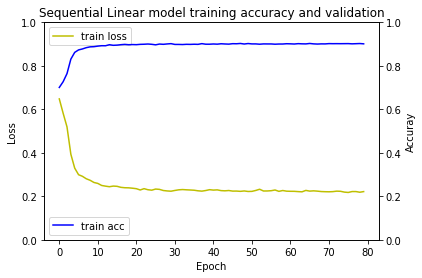

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(sim_model_train.history['loss'], 'y', label='loss')
acc_ax.plot(sim_model_train.history['accuracy'], 'b', label='accuracy')

loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
acc_ax.set_ylabel('Accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.title('Sequential Linear model accuracy and validation')
plt.show()
#https://github.com/sharmaroshan/Drugs-Recommendation-using-Reviews/blob/master/DrugsAnalysis.ipynb

In [ ]:
def avergae_lst(lst):
    return round((sum(lst) / len(lst)),2)

In [ ]:
#Adding simple sequential model data to report table-
from math import sqrt

sim_model_name='Simple Sequential Linear Neural Network'
sim_model_acc=avergae_lst(sim_model_train.history['acc'])
sim_rmse_score=sqrt(avergae_lst(sim_model_train.history['mse']))
sim_mse_score=avergae_lst(sim_model_train.history['mse'])
report=pd.concat([report,pd.DataFrame([[sim_model_name,'', sim_model_acc,0,sim_rmse_score,sim_mse_score,0,0,0]] ,columns = ['Model name', 'Model parameter', 'Accuracy', 'ROC AUC score','RMSE score','MSE score','Precision','F1_score','Recall']),axis=1)


#### Convolutional neural network

In [37]:
cnn_model = Sequential()
cnn_model.add(keras.layers.Embedding(8000, 200, input_length=8000))
cnn_model.add(keras.layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(10, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='softmax'))
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy','mse'])
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8000, 200)         1600000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7996, 128)         128128    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 1,729,429
Trainable params: 1,729,429
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_model_train = cnn_model.fit(X_train_cv.todense(), y_train, epochs=10, batch_size=100)

Epoch 1/10
60/60 [==============================] - 784s 13s/step - loss: 0.5964 - accuracy: 0.7302 - mse: 0.2698
Epoch 2/10
60/60 [==============================] - 770s 13s/step - loss: 0.5852 - accuracy: 0.7288 - mse: 0.2712
Epoch 3/10
60/60 [==============================] - 775s 13s/step - loss: 0.5818 - accuracy: 0.7346 - mse: 0.2654
Epoch 4/10
60/60 [==============================] - 770s 13s/step - loss: 0.5926 - accuracy: 0.7236 - mse: 0.2764
Epoch 5/10
60/60 [==============================] - 773s 13s/step - loss: 0.5908 - accuracy: 0.7233 - mse: 0.2767
Epoch 6/10
15/60 [======>.......................] - ETA: 9:47 - loss: 0.6031 - accuracy: 0.7146 - mse: 0.2854 

Carrying out loss vs accuracy trade off for convolutional neural network using visuals

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(cnn_model_train.history['loss'], 'y', label='loss')
acc_ax.plot(cnn_model_train.history['accuracy'], 'b', label='accuracy')

loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
acc_ax.set_ylabel('Accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
#https://github.com/sharmaroshan/Drugs-Recommendation-using-Reviews/blob/master/DrugsAnalysis.ipynb

Visualizing the mse scores of both simple sequential and convolutional neural network.

In [ ]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(sim_model_train.history['mse'],label='CNN MSE score')
pyplot.plot(cnn_model_train.history['mse'],label='Sequential MSE score')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')


pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
#Adding simple sequential model data to report table-

cnn_model_name='Convolutional Neural Network'
cnn_model_acc=avergae_lst(cnn_model_train.history['acc'])
cnn_rmse_score=sqrt(avergae_lst(cnn_model_train.history['mse']))
cnn_mse_score=avergae_lst(cnn_model_train.history['mse'])
report=pd.concat([report,pd.DataFrame([[cnn_model_name,'', cnn_model_acc,0,cnn_rmse_score,cnn_mse_score,0,0,0]] ,columns = ['Model name', 'Model parameter', 'Accuracy', 'ROC AUC score','RMSE score','MSE score','Precision','F1_score','Recall']),axis=1)


In [ ]:
#checking for the best model for the recommendation system
report

Looking at the above table it appears, simple sequential neural network and LinearSVC will be the best for our recommendation system based on the accuracy. Further looking into the MSE scores, It can be concluded simple sequential neural network will provide best results among all the model. 

Carrying out the predictions/recommendations using simple sequential neural network.

#### Predictions

In [ ]:
Print

In [ ]:
def predicted_recommend(predictions,testing_data):

  predict_df=pd.DataFrame(testing_data.sentiment)
  predict_df['predicted_values']=pd.Series(predictions, index=predict_df.index)
  recommend_index=list(predict_df[predict_df['predicted_values']=='1'].index)
  recommend_dataframe=testing_data.loc[recommend_index]
  recommend_dataframe_grouped=recommend_dataframe[['drugName','rating']].groupby(['drugName']).max()
  recommend_dataframe_grouped.sort_values(by='rating', ascending=False)[:10]
  recommend_dataframe_grouped=recommend_dataframe_grouped.reset_index()
  recommend_dataframe_grouped=recommend_dataframe_grouped.sort_values(by='rating', ascending=False)[:10]
 
  return recommend_dataframe_grouped

In [ ]:
predicted_recommend(predictions,testing_data)